<a href="https://colab.research.google.com/github/Dan77111/MLProject/blob/main/ML_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Init

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import csv 

from google.colab import drive

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data.sampler import SubsetRandomSampler

from torchvision import datasets, transforms

from sklearn import neighbors
from sklearn import tree
from sklearn import ensemble
from sklearn import svm
import torchvision.models as models

import gc

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

INPUT_DIM = 224*224*3
DATA_FOR_VALIDATION = 0.2
N_CLASSES = 10
BATCH_SIZE = 128
N_EPOCHS = 20
RF_MIN_SAMPLES_LEAF = 15


In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# Utils


In [ ]:
print(torch.cuda.get_device_name(0))

Tesla T4


In [ ]:
gc.collect()

6698

In [ ]:
torch.cuda.empty_cache()

# Data Loading

**Decompress the dataset**

In [ ]:
!tar -xzvf "/content/drive/My Drive/ML/dataset-002.tar.gz" -C "/content/drive/My Drive/ML/Dataset"

In [ ]:
!tar -xzvf "/content/drive/My Drive/ML/dataset-002.tar.gz"

Streaming output truncated to the last 5000 lines.
dataset/test/4672.png
dataset/test/3221.png
dataset/test/2956.png
dataset/test/2552.png
dataset/test/4837.png
dataset/test/1306.png
dataset/test/835.png
dataset/test/1858.png
dataset/test/2669.png
dataset/test/4675.png
dataset/test/1366.png
dataset/test/3322.png
dataset/test/659.png
dataset/test/4589.png
dataset/test/818.png
dataset/test/1045.png
dataset/test/2880.png
dataset/test/4133.png
dataset/test/50.png
dataset/test/1839.png
dataset/test/5064.png
dataset/test/3288.png
dataset/test/2366.png
dataset/test/4763.png
dataset/test/2437.png
dataset/test/2510.png
dataset/test/296.png
dataset/test/558.png
dataset/test/1352.png
dataset/test/193.png
dataset/test/5154.png
dataset/test/138.png
dataset/test/543.png
dataset/test/5183.png
dataset/test/2252.png
dataset/test/1579.png
dataset/test/5107.png
dataset/test/1793.png
dataset/test/1095.png
dataset/test/5320.png
dataset/test/1962.png
dataset/test/5010.png
dataset/test/2631.png
dataset/test/

**Set the drive folders for the parts of the dataset**

In [ ]:
DATASET_DIR = '/content/drive/My Drive/ML/Dataset/dataset'

# training dataset
TRAIN_DATASET_DIR = DATASET_DIR +'/train'

# test dataset to submit
TEST_DATASET_DIR = DATASET_DIR + '/test'

**Set the folders local to the Google machine for the parts of the dataset**

In [ ]:
DATASET_DIR = 'dataset'

# training dataset
TRAIN_DATASET_DIR = DATASET_DIR + '/train'

# test dataset to submit
TEST_DATASET_DIR = DATASET_DIR + '/test'

In [ ]:
temp_dir = DATASET_DIR + '/temp'
temp_test_dir = temp_dir + '/test'
test_test_dir = TEST_DATASET_DIR + '/test'
!mkdir {temp_dir}
!mv {TEST_DATASET_DIR} {temp_test_dir}
!mkdir {TEST_DATASET_DIR}
!mv {temp_test_dir} {test_test_dir}
!rm -r {temp_dir}

**Load the dataset and split it in training and validation**

In [ ]:
def load_and_split():

  #transformation tools
  tr_composition = transforms.Compose([
                  transforms.Resize(256),
                  transforms.CenterCrop(224),
                  transforms.ToTensor(),
                  transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])                 
                ])

  #data folders
  folders = { x : datasets.ImageFolder(TRAIN_DATASET_DIR, transform = tr_composition) for x in ['train', 'val']}

  #split training and validation datasets
  train_set_size = len(folders['train'])
  indexes = list(range(train_set_size))
  split = int(np.floor(DATA_FOR_VALIDATION * train_set_size))
  np.random.shuffle(indexes)

  index = {'train': indexes[split:], 'val': indexes[:split]}

  sampler = {'train': SubsetRandomSampler(index['train']), 'val': SubsetRandomSampler(index['val'])}

  #define data loaders
  loaders = {x : torch.utils.data.DataLoader(folders[x], sampler=sampler[x], batch_size=BATCH_SIZE) for x in ['train', 'val']}
  
  test_folder = datasets.ImageFolder(TEST_DATASET_DIR, transform = tr_composition)

  test_loader = torch.utils.data.DataLoader(test_folder, batch_size=BATCH_SIZE)

  return loaders, test_loader

loaders, test_loader = load_and_split()

# Feature Extraction

**Resnet18**

In [ ]:
model_resnet18 = models.resnet18(pretrained=True).to(device)
n_features = model_resnet18.fc.in_features
model_resnet18.fc = nn.Linear(n_features, N_CLASSES).to(device)

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

**Resnet50**

In [ ]:
model_resnet50 = models.resnet50(pretrained=True).to(device)
n_features = model_resnet50.fc.in_features
model_resnet50.fc = nn.Linear(n_features, N_CLASSES).to(device)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [ ]:
#load saved state of resnet18
model_resnet18, optimizer18, epoch, loss = load_model(model_resnet18, optimizer18, "/content/drive/My Drive/ML/Saved Models/resnet_18.pt")

In [ ]:
#load saved state of resnet50
model_resnet50, optimizer50, epoch, loss = load_model(model_resnet50, optimizer50, "/content/drive/My Drive/ML/Saved Models/resnet_50.pt")

In [ ]:
#stored features for training and validation
features_trainset_18 = []
features_valset_18 = []
features_trainset_50 = []
features_valset_50 = []

#stored features for testset
features_testset = []

#feature labels
labels_trainset_18 = []
labels_valset_18 = []
labels_trainset_50 = []
labels_valset_50 = []

with torch.no_grad():
  #extract features from training set with both a resnet18 and a resnet50
  for X, y in loaders['train']:
    X = X.to(device)
    y = y.to(device)
    features_trainset_18.append(model_resnet18(X))
    features_trainset_50.append(model_resnet50(X))
    labels_trainset_18.append(y)
    labels_trainset_50.append(y)

  #extract features from validation set with both a resnet18 and a resnet50
  for X, y in loaders['val']:
    X = X.to(device)
    y = y.to(device)
    features_valset_18.append(model_resnet18(X))
    features_valset_50.append(model_resnet50(X))
    labels_valset_18.append(y)
    labels_valset_50.append(y)

  #extract features from test set
  for X, _ in test_loader:
    X = X.to(device)
    features_testset.append(model_resnet50(X))

features_trainset_18 = torch.cat(features_trainset_18, dim=0).to('cpu')
features_valset_18 = torch.cat(features_valset_18, dim=0).to('cpu')
features_trainset_50 = torch.cat(features_trainset_50, dim=0).to('cpu')
features_valset_50 = torch.cat(features_valset_50, dim=0).to('cpu')
features_testset = torch.cat(features_testset, dim=0).to('cpu')
labels_trainset_18 = torch.cat(labels_trainset_18, dim=0).to('cpu')
labels_valset_18 = torch.cat(labels_valset_18, dim=0).to('cpu')
labels_trainset_50 = torch.cat(labels_trainset_50, dim=0).to('cpu')
labels_valset_50 = torch.cat(labels_valset_50, dim=0).to('cpu')

# Save features to file and load them

**Save all the features to drive to avoid executing feature extraction every day**

In [ ]:
torch.save(features_trainset_18, '/content/drive/My Drive/ML/Feature Tensors/features_trainset_18.pt')
torch.save(features_valset_18, '/content/drive/My Drive/ML/Feature Tensors/features_valset_18.pt')
torch.save(features_trainset_50, '/content/drive/My Drive/ML/Feature Tensors/features_trainset_50.pt')
torch.save(features_valset_50, '/content/drive/My Drive/ML/Feature Tensors/features_valset_50.pt')

torch.save(labels_trainset_18, '/content/drive/My Drive/ML/Feature Tensors/labels_trainset_18.pt')
torch.save(labels_valset_18, '/content/drive/My Drive/ML/Feature Tensors/labels_valset_18.pt')
torch.save(labels_trainset_50, '/content/drive/My Drive/ML/Feature Tensors/labels_trainset_50.pt')
torch.save(labels_valset_50, '/content/drive/My Drive/ML/Feature Tensors/labels_valset_50.pt')

In [ ]:
torch.save(features_trainset_18, '/content/drive/My Drive/ML/Feature Tensors/trained_features_trainset_18.pt')
torch.save(features_valset_18, '/content/drive/My Drive/ML/Feature Tensors/trained_features_valset_18.pt')
torch.save(features_trainset_50, '/content/drive/My Drive/ML/Feature Tensors/trained_features_trainset_50.pt')
torch.save(features_valset_50, '/content/drive/My Drive/ML/Feature Tensors/trained_features_valset_50.pt')

torch.save(labels_trainset_18, '/content/drive/My Drive/ML/Feature Tensors/trained_labels_trainset_18.pt')
torch.save(labels_valset_18, '/content/drive/My Drive/ML/Feature Tensors/trained_labels_valset_18.pt')
torch.save(labels_trainset_50, '/content/drive/My Drive/ML/Feature Tensors/trained_labels_trainset_50.pt')
torch.save(labels_valset_50, '/content/drive/My Drive/ML/Feature Tensors/trained_labels_valset_50.pt')

**Load feature tensors from drive**

In [ ]:
features_trainset_18 = torch.load('/content/drive/My Drive/ML/Feature Tensors/features_trainset_18.pt')
features_valset_18 = torch.load('/content/drive/My Drive/ML/Feature Tensors/features_valset_18.pt')
features_trainset_50 = torch.load('/content/drive/My Drive/ML/Feature Tensors/features_trainset_50.pt')
features_valset_50 = torch.load('/content/drive/My Drive/ML/Feature Tensors/features_valset_50.pt')

labels_trainset_18 = torch.load('/content/drive/My Drive/ML/Feature Tensors/labels_trainset_18.pt')
labels_valset_18 = torch.load('/content/drive/My Drive/ML/Feature Tensors/labels_valset_18.pt')
labels_trainset_50 = torch.load('/content/drive/My Drive/ML/Feature Tensors/labels_trainset_50.pt')
labels_valset_50 = torch.load('/content/drive/My Drive/ML/Feature Tensors/labels_valset_50.pt')

In [ ]:
features_trainset_18 = torch.load('/content/drive/My Drive/ML/Feature Tensors/trained_features_trainset_18.pt')
features_valset_18 = torch.load('/content/drive/My Drive/ML/Feature Tensors/trained_features_valset_18.pt')
features_trainset_50 = torch.load('/content/drive/My Drive/ML/Feature Tensors/trained_features_trainset_50.pt')
features_valset_50 = torch.load('/content/drive/My Drive/ML/Feature Tensors/trained_features_valset_50.pt')

labels_trainset_18 = torch.load('/content/drive/My Drive/ML/Feature Tensors/trained_labels_trainset_18.pt')
labels_valset_18 = torch.load('/content/drive/My Drive/ML/Feature Tensors/trained_labels_valset_18.pt')
labels_trainset_50 = torch.load('/content/drive/My Drive/ML/Feature Tensors/trained_labels_trainset_50.pt')
labels_valset_50 = torch.load('/content/drive/My Drive/ML/Feature Tensors/trained_labels_valset_50.pt')

# Accuracy Calculation (generic)

**Class to calculate accuracy**

In [ ]:
class AccuracyCalculator():
  def __init__(self, is_cuda=False):
    self.CM = torch.zeros(N_CLASSES, N_CLASSES)
    if is_cuda:
      self.CM = self.CM.to(device)

  def add_data(self, predicted_label, true_label):
    with torch.no_grad():
      for yp, yt in zip(predicted_label, true_label):
        self.CM[yt,yp] = self.CM[yt,yp] + 1
      
  def clear(self):
    self.CM.zero_()

  def global_acc(self):
    return self.CM.diag().sum().item()/self.CM.sum().item() #va item o no?

  def class_wise_acc(self):
    return np.mean([self.CM.diag()[x].item()/(self.CM.sum(0)[x].item() or 1) for x in range(10)])

  def confusion_matrix():
    return self.CM

accuracy_calculator = AccuracyCalculator()

# Graph creation (generic for shallow methods)

**Class to handle the graphs for the shallow methods**

In [ ]:
class Graph:
  def __init__(self):
    self.clear()

  def clear(self):
    self.gacc_trainset_18 = []
    self.gacc_trainset_50 = []
    self.gacc_valset_18 = []
    self.gacc_valset_50 = []

    self.cwacc_trainset_18 = []
    self.cwacc_trainset_50 = []
    self.cwacc_valset_18 = []
    self.cwacc_valset_50 = []

    self.x_values = []


  def rename(self, title):
    self.title = title

  def add_gacc(self, gacc_trainset_18, gacc_trainset_50, gacc_valset_18, gacc_valset_50):
    self.gacc_trainset_18.append(gacc_trainset_18)
    self.gacc_trainset_50.append(gacc_trainset_50)
    self.gacc_valset_18.append(gacc_valset_18)
    self.gacc_valset_50.append(gacc_valset_50)
  
  def add_cwacc(self, cwacc_trainset_18, cwacc_trainset_50, cwacc_valset_18, cwacc_valset_50):
    self.cwacc_trainset_18.append(cwacc_trainset_18)
    self.cwacc_trainset_50.append(cwacc_trainset_50)
    self.cwacc_valset_18.append(cwacc_valset_18)
    self.cwacc_valset_50.append(cwacc_valset_50)

  def add_data(self, x_value, gacc_trainset_18, gacc_trainset_50, gacc_valset_18, gacc_valset_50, cwacc_trainset_18, cwacc_trainset_50, cwacc_valset_18, cwacc_valset_50):
    self.x_values.append(x_value)
    self.add_gacc(gacc_trainset_18, gacc_trainset_50, gacc_valset_18, gacc_valset_50)
    self.add_cwacc(cwacc_trainset_18, cwacc_trainset_50, cwacc_valset_18, cwacc_valset_50)

  def return_data(self):
    return self.x_values, [self.gacc_trainset_18, self.gacc_trainset_50, self.gacc_valset_18, self.gacc_valset_50], [self.cwacc_trainset_18, self.cwacc_trainset_50, self.cwacc_valset_18, self.cwacc_valset_50]

  def display(self, xlabel):
    container, (gacc, cwacc) = plt.subplots(2)
    container.suptitle(self.title)
    gacc.plot(self.x_values, self.gacc_trainset_18, color='red', marker='.', label='trainset_18', linestyle = 'None')
    gacc.plot(self.x_values, self.gacc_trainset_50, color='orange', marker='.', label='trainset_50', linestyle = 'None')
    gacc.plot(self.x_values, self.gacc_valset_18, color='blue', marker='.', label='valset_18', linestyle = 'None')
    gacc.plot(self.x_values, self.gacc_valset_50, color='green', marker='.', label='valset_50', linestyle = 'None')
    cwacc.plot(self.x_values, self.cwacc_trainset_18, color='red', marker='.', label='trainset_18', linestyle = 'None')
    cwacc.plot(self.x_values, self.cwacc_trainset_50, color='orange', marker='.', label='trainset_50', linestyle = 'None')
    cwacc.plot(self.x_values, self.cwacc_valset_18, color='blue', marker='.', label='valset_18', linestyle = 'None')
    cwacc.plot(self.x_values, self.cwacc_valset_50, color='green', marker='.', label='valset_50', linestyle = 'None')
    gacc.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
    cwacc.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
    gacc.set_ylabel('SW_Acc')
    cwacc.set_ylabel('CW_Acc')
    gacc.set_xlabel(xlabel)
    cwacc.set_xlabel(xlabel)

graph = Graph()

# Validation function (generic for shallow methods)

**Generic validation function called by every shallow model to test them on validation dataset and compute accuracy**

In [ ]:
#model_18 is the model trained on the features extracted by resnet18, same for 50
def validate(model_18, model_50, model_type, n_neighbors = 0, criterion = '', min_samples_leaf = 0, n_estimators = 0, kernel = '', C = 0):
  with torch.no_grad():
    predicted_labels_trainset_18 = model_18.predict(features_trainset_18)
    predicted_labels_trainset_50 = model_50.predict(features_trainset_50)

    predicted_labels_valset_18 = model_18.predict(features_valset_18)
    predicted_labels_valset_50 = model_50.predict(features_valset_50)
    
    accuracy_calculator.add_data(predicted_labels_trainset_18, labels_trainset_18)
    gacc_trainset_18, cwacc_trainset_18 = accuracy_calculator.global_acc(), accuracy_calculator.class_wise_acc()
    accuracy_calculator.clear()

    accuracy_calculator.add_data(predicted_labels_trainset_50, labels_trainset_50)
    gacc_trainset_50, cwacc_trainset_50 = accuracy_calculator.global_acc(), accuracy_calculator.class_wise_acc()
    accuracy_calculator.clear()

    accuracy_calculator.add_data(predicted_labels_valset_18, labels_valset_18)
    gacc_valset_18, cwacc_valset_18 = accuracy_calculator.global_acc(), accuracy_calculator.class_wise_acc()
    accuracy_calculator.clear()

    accuracy_calculator.add_data(predicted_labels_valset_50, labels_valset_50)
    gacc_valset_50, cwacc_valset_50 = accuracy_calculator.global_acc(), accuracy_calculator.class_wise_acc()
    accuracy_calculator.clear()

    if model_type == "knn":
      graph.rename("KNN - K Nearest Neighbors")
      graph.add_data(n_neighbors, gacc_trainset_18, gacc_trainset_50, gacc_valset_18, gacc_valset_50, cwacc_trainset_18, cwacc_trainset_50, cwacc_valset_18, cwacc_valset_50)
    elif model_type == "dt":
      graph.rename("DT - Decision Tree - " + criterion.capitalize())
      graph.add_data(min_samples_leaf, gacc_trainset_18, gacc_trainset_50, gacc_valset_18, gacc_valset_50, cwacc_trainset_18, cwacc_trainset_50, cwacc_valset_18, cwacc_valset_50)
    elif model_type == "rf":
      graph.rename("RF - Random Forest - " + criterion.capitalize())
      graph.add_data(n_estimators, gacc_trainset_18, gacc_trainset_50, gacc_valset_18, gacc_valset_50, cwacc_trainset_18, cwacc_trainset_50, cwacc_valset_18, cwacc_valset_50)
    elif model_type == "svm":
      graph.rename("SVM - Support Vector Machine - " + kernel.capitalize() + " Kernel")
      graph.add_data(C, gacc_trainset_18, gacc_trainset_50, gacc_valset_18, gacc_valset_50, cwacc_trainset_18, cwacc_trainset_50, cwacc_valset_18, cwacc_valset_50)

    

temp

# KNN - K Nearest Neighbor

**Training and Validation using KNN**

Global Accuracy
------------------------------------------------
         | train18 | train50 | valid18 | valid50
------------------------------------------------
  1 nbrs | 100.00% | 100.00% |  61.38% |  81.84%
-----------------------------------------------
  2 nbrs |  80.08% |  92.28% |  58.72% |  80.91%
-----------------------------------------------
  3 nbrs |  78.01% |  91.70% |  63.07% |  84.62%
-----------------------------------------------
  4 nbrs |  76.87% |  91.38% |  65.36% |  84.49%
-----------------------------------------------
  5 nbrs |  75.76% |  90.94% |  66.69% |  85.50%
-----------------------------------------------
  6 nbrs |  74.85% |  90.63% |  67.54% |  85.70%
-----------------------------------------------
  7 nbrs |  74.18% |  90.48% |  67.22% |  85.70%
-----------------------------------------------
  8 nbrs |  73.78% |  90.30% |  67.50% |  86.51%
-----------------------------------------------
  9 nbrs |  73.38% |  89.97% |  68.39% |  85.98%
------------

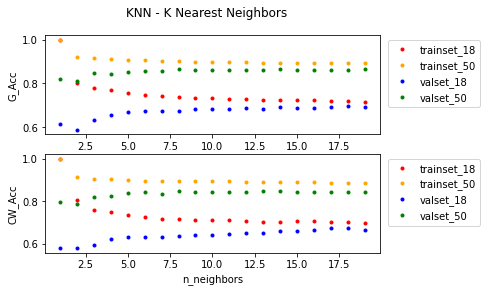

In [ ]:
for n in range(1,20):
  model_knn_18 = neighbors.KNeighborsClassifier(n_neighbors=n, n_jobs=-1)
  model_knn_18.fit(features_trainset_18, labels_trainset_18)
  model_knn_50 = neighbors.KNeighborsClassifier(n_neighbors=n, n_jobs=-1)
  model_knn_50.fit(features_trainset_50, labels_trainset_50)

  validate(model_knn_18, model_knn_50, model_type="knn", n_neighbors=n)

graph.display('n_neighbors')
x_values, gacc, cwacc = graph.return_data()
graph.clear()

print("Sample-Wise Accuracy")
print("------------------------------------------------")
print("         | train18 | train50 | valid18 | valid50")
print("------------------------------------------------")
for i, x in enumerate(x_values):
  print("{:3} nbrs | {:7.2%} | {:7.2%} | {:7.2%} | {:7.2%}".format(x, gacc[0][i], gacc[1][i], gacc[2][i], gacc[3][i]))
  print("-----------------------------------------------")

print("Class-Wise Accuracy")
print("------------------------------------------------")
print("         | train18 | train50 | valid18 | valid50")
print("------------------------------------------------")
for i, x in enumerate(x_values):
  print("{:3} nbrs | {:7.2%} | {:7.2%} | {:7.2%} | {:7.2%}".format(x, cwacc[0][i], cwacc[1][i], cwacc[2][i], cwacc[3][i]))
  print("------------------------------------------------")

# DT - Decision Tree

**Training and Validation using DT**

Gini
Global Accuracy
------------------------------------------------
         | train18 | train50 | valid18 | valid50
------------------------------------------------
  1 m_sl | 100.00% | 100.00% |  59.04% |  81.72%
-----------------------------------------------
  2 m_sl |  91.49% |  96.21% |  59.40% |  81.59%
-----------------------------------------------
  5 m_sl |  82.44% |  92.93% |  62.51% |  83.93%
-----------------------------------------------
 10 m_sl |  77.14% |  91.21% |  65.28% |  85.14%
-----------------------------------------------
 15 m_sl |  74.93% |  90.19% |  66.21% |  85.78%
-----------------------------------------------
 20 m_sl |  73.82% |  89.84% |  67.34% |  85.66%
-----------------------------------------------
 25 m_sl |  73.27% |  89.27% |  67.70% |  85.90%
-----------------------------------------------
 30 m_sl |  72.43% |  89.04% |  67.66% |  85.62%
-----------------------------------------------
Class-Wise Accuracy
------------------------------------

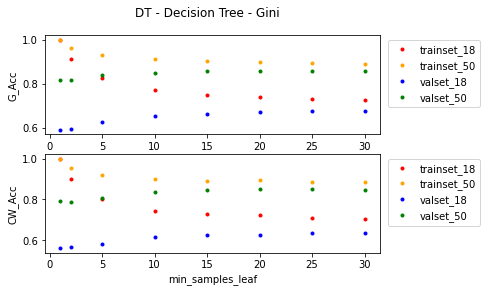

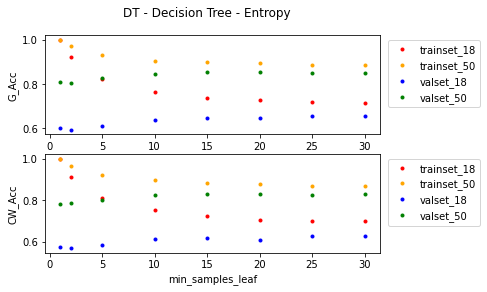

In [ ]:
for crt in ['gini', 'entropy']:
  for msl in [1,2,5,10,15,20,25,30]:
    model_dt_18 = tree.DecisionTreeClassifier(criterion=crt, min_samples_leaf=msl)
    model_dt_18.fit(features_trainset_18, labels_trainset_18)
    model_dt_50 = tree.DecisionTreeClassifier(criterion=crt, min_samples_leaf=msl)
    model_dt_50.fit(features_trainset_50, labels_trainset_50)

    validate(model_dt_18, model_dt_50, model_type="dt", criterion=crt, min_samples_leaf=msl)

  graph.display('min_samples_leaf')
  x_values, gacc, cwacc = graph.return_data()
  graph.clear()

  print(crt.capitalize())
  print("Sample-Wise Accuracy")
  print("------------------------------------------------")
  print("         | train18 | train50 | valid18 | valid50")
  print("------------------------------------------------")
  for i, x in enumerate(x_values):
    print("{:3} m_sl | {:7.2%} | {:7.2%} | {:7.2%} | {:7.2%}".format(x, gacc[0][i], gacc[1][i], gacc[2][i], gacc[3][i]))
    print("-----------------------------------------------")

  print("Class-Wise Accuracy")
  print("------------------------------------------------")
  print("         | train18 | train50 | valid18 | valid50")
  print("------------------------------------------------")
  for i, x in enumerate(x_values):
    print("{:3} m_sl | {:7.2%} | {:7.2%} | {:7.2%} | {:7.2%}".format(x, cwacc[0][i], cwacc[1][i], cwacc[2][i], cwacc[3][i]))
    print("------------------------------------------------")

# RF - Random Forest

**Training and Validation using RF**

Gini
Global Accuracy
-------------------------------------------------
          | train18 | train50 | valid18 | valid50
-------------------------------------------------
  5 n_est |  74.41% |  90.05% |  68.22% |  85.94%
------------------------------------------------
 10 n_est |  74.47% |  90.30% |  69.51% |  86.39%
------------------------------------------------
 25 n_est |  75.09% |  90.88% |  68.75% |  86.19%
------------------------------------------------
 50 n_est |  75.69% |  91.14% |  69.75% |  86.87%
------------------------------------------------
100 n_est |  75.72% |  91.16% |  69.39% |  86.79%
------------------------------------------------
Class-Wise Accuracy
-------------------------------------------------
          | train18 | train50 | valid18 | valid50
-------------------------------------------------
  5 n_est |  73.28% |  88.87% |  64.47% |  83.46%
-------------------------------------------------
 10 n_est |  73.02% |  89.71% |  67.75% |  85.06%
--------------

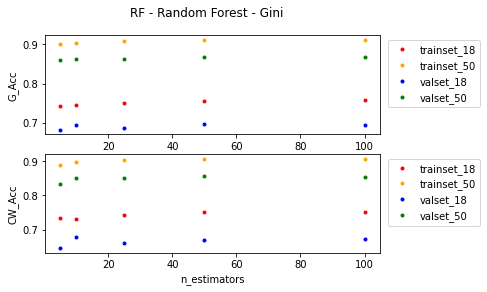

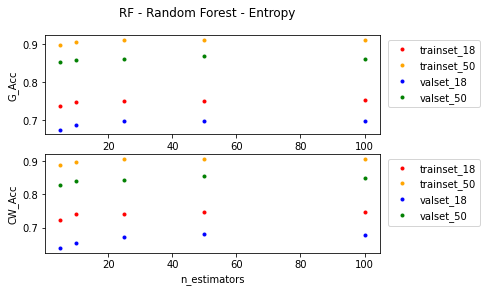

In [ ]:
for crt in ['gini', 'entropy']:
  for n_est in [5,10,25,50,100]:
    model_rf_18 = ensemble.RandomForestClassifier(n_estimators=n_est, criterion=crt, min_samples_leaf=RF_MIN_SAMPLES_LEAF)
    model_rf_18.fit(features_trainset_18, labels_trainset_18)
    model_rf_50 = ensemble.RandomForestClassifier(n_estimators=n_est, criterion=crt, min_samples_leaf=RF_MIN_SAMPLES_LEAF)
    model_rf_50.fit(features_trainset_50, labels_trainset_50)

    validate(model_rf_18, model_rf_50, model_type="rf", n_estimators=n_est, criterion=crt)
  
  graph.display('n_estimators')
  x_values, gacc, cwacc = graph.return_data()
  graph.clear()

  print(crt.capitalize())
  print("Sample-Wise Accuracy")
  print("-------------------------------------------------")
  print("          | train18 | train50 | valid18 | valid50")
  print("-------------------------------------------------")
  for i, x in enumerate(x_values):
    print("{:3} n_est | {:7.2%} | {:7.2%} | {:7.2%} | {:7.2%}".format(x, gacc[0][i], gacc[1][i], gacc[2][i], gacc[3][i]))
    print("------------------------------------------------")

  print("Class-Wise Accuracy")
  print("-------------------------------------------------")
  print("          | train18 | train50 | valid18 | valid50")
  print("-------------------------------------------------")
  for i, x in enumerate(x_values):
    print("{:3} n_est | {:7.2%} | {:7.2%} | {:7.2%} | {:7.2%}".format(x, cwacc[0][i], cwacc[1][i], cwacc[2][i], cwacc[3][i]))
    print("-------------------------------------------------")

# SVM - Support Vector Machine

**Training and Validation using SVM**

Linear
Global Accuracy
-------------------------------------------------
          | train18 | train50 | valid18 | valid50
-------------------------------------------------
0.1 regP |  71.47% |  90.52% |  70.16% |  88.64%
------------------------------------------------
0.5 regP |  71.58% |  90.60% |  70.48% |  88.88%
------------------------------------------------
  1 regP |  71.59% |  90.60% |  70.36% |  89.01%
------------------------------------------------
  5 regP |  71.62% |  90.64% |  70.44% |  88.84%
------------------------------------------------
 10 regP |  71.59% |  90.63% |  70.48% |  88.80%
------------------------------------------------
Class-Wise Accuracy
-------------------------------------------------
          | train18 | train50 | valid18 | valid50
-------------------------------------------------
0.1 regP |  69.84% |  89.59% |  66.99% |  86.86%
-------------------------------------------------
0.5 regP |  69.90% |  89.82% |  67.66% |  87.96%
-------------------

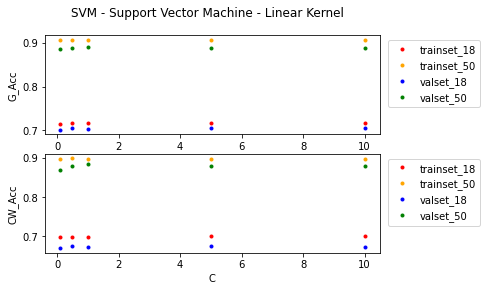

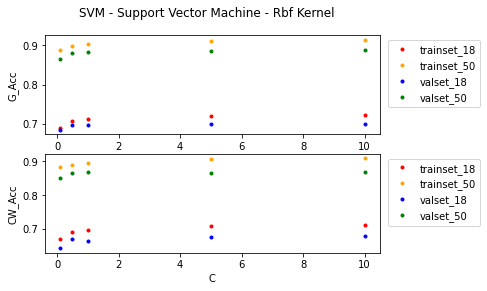

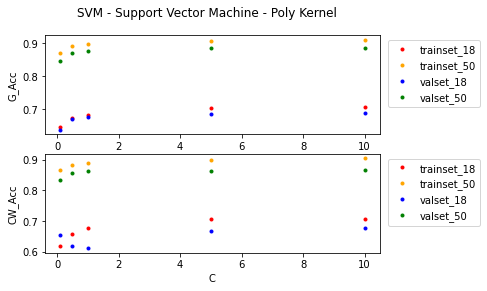

In [ ]:
for krn in ['linear', 'rbf', 'poly']:
  for c in [0.1,0.5,1,5,10]:
    model_svm_18 = svm.SVC(kernel=krn, C=c)
    model_svm_18.fit(features_trainset_18, labels_trainset_18)
    model_svm_50 = svm.SVC(kernel=krn, C=c)
    model_svm_50.fit(features_trainset_50, labels_trainset_50)

    if krn == 'linear' and c == 1:
      predicted_labels_testset = model_svm_50.predict(features_testset)

    validate(model_svm_18, model_svm_50, model_type="svm", kernel=krn, C=c)
  
  graph.display('C')
  x_values, gacc, cwacc = graph.return_data()
  graph.clear()

  print(krn.capitalize())
  print("Sample-Wise Accuracy")
  print("-------------------------------------------------")
  print("          | train18 | train50 | valid18 | valid50")
  print("-------------------------------------------------")
  for i, x in enumerate(x_values):
    print("{:3} regP | {:7.2%} | {:7.2%} | {:7.2%} | {:7.2%}".format(x, gacc[0][i], gacc[1][i], gacc[2][i], gacc[3][i]))
    print("------------------------------------------------")

  print("Class-Wise Accuracy")
  print("-------------------------------------------------")
  print("          | train18 | train50 | valid18 | valid50")
  print("-------------------------------------------------")
  for i, x in enumerate(x_values):
    print("{:3} regP | {:7.2%} | {:7.2%} | {:7.2%} | {:7.2%}".format(x, cwacc[0][i], cwacc[1][i], cwacc[2][i], cwacc[3][i]))
    print("-------------------------------------------------")

# Neural Networks

**Functions to save and load models to avoid retraining them every time**

In [ ]:
def save_model(model, optimizer, epoch, loss, path):
  torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': loss
            }, path)
  
def load_model(model, optimizer, path):
  checkpoint = torch.load(path)
  model.load_state_dict(checkpoint['model_state_dict'])
  optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
  epoch = checkpoint['epoch']
  loss = checkpoint['loss']
  return model, optimizer, epoch, loss

The NNs I used are 2 resnets (18 and 50) and **TODO**

**model_resnet18 and model_resnet50 are already initialized during the feature extraction section**

**Elements necessary for NNs**

In [ ]:
loss_fn = nn.CrossEntropyLoss()

In [ ]:
optimizer18 = optim.SGD(model_resnet18.parameters(), lr=0.1, momentum=0.9)
scheduler18 = optim.lr_scheduler.MultiStepLR(optimizer18, [10,15], gamma=0.5)

optimizer50 = optim.SGD(model_resnet50.parameters(), lr=0.1, momentum=0.9)
scheduler50 = optim.lr_scheduler.MultiStepLR(optimizer50, [10,15], gamma=0.5)

**Class to handle the graphs for NNs**

In [ ]:
class NNGraph:
  def __init__(self):
    self.clear()

  def clear(self):
    self.gacc_trainset = []
    self.gacc_valset = []

    self.cwacc_trainset = []
    self.cwacc_valset = []

    self.x_values = []


  def rename(self, title):
    self.title = title

  def add_gacc(self, gacc_trainset, gacc_valset):
    self.gacc_trainset.append(gacc_trainset)
    self.gacc_valset.append(gacc_valset)
  
  def add_cwacc(self, cwacc_trainset, cwacc_valset):
    self.cwacc_trainset.append(cwacc_trainset)
    self.cwacc_valset.append(cwacc_valset)

  def add_data(self, x_value, gacc_trainset, gacc_valset, cwacc_trainset, cwacc_valset):
    self.x_values.append(x_value)
    self.add_gacc(gacc_trainset, gacc_valset)
    self.add_cwacc(cwacc_trainset, cwacc_valset)

  def return_data(self):
    return self.x_values, [self.gacc_trainset, self.gacc_valset], [self.cwacc_trainset, self.cwacc_valset]

  def display(self, xlabel):
    container, (gacc, cwacc) = plt.subplots(2)
    container.suptitle(self.title)
    gacc.plot(self.x_values, self.gacc_trainset, color='red', marker='.', label='trainset', linestyle = 'None')
    gacc.plot(self.x_values, self.gacc_valset, color='blue', marker='.', label='valset', linestyle = 'None')
    cwacc.plot(self.x_values, self.cwacc_trainset, color='red', marker='.', label='trainset', linestyle = 'None')
    cwacc.plot(self.x_values, self.cwacc_valset, color='blue', marker='.', label='valset', linestyle = 'None')
    gacc.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
    cwacc.legend(loc='upper left', bbox_to_anchor=(1.01, 1))
    gacc.set_ylabel('SW_Acc')
    cwacc.set_ylabel('CW_Acc')
    gacc.set_xlabel(xlabel)
    cwacc.set_xlabel(xlabel)

nngraph = NNGraph()

**Training and Validation**

**RESNET18**

[][]  Epoch 1/20 [][]
Training: Global Accuracy:  14.32%, Class-wise Accuracy:  12.34%
Validation: Global Accuracy:  16.15%, Class-wise Accuracy:   8.50%
[][]  Epoch 2/20 [][]
Training: Global Accuracy:  19.65%, Class-wise Accuracy:  15.10%
Validation: Global Accuracy:  23.44%, Class-wise Accuracy:  17.08%
[][]  Epoch 3/20 [][]
Training: Global Accuracy:  26.94%, Class-wise Accuracy:  24.33%
Validation: Global Accuracy:  28.84%, Class-wise Accuracy:  23.94%
[][]  Epoch 4/20 [][]
Training: Global Accuracy:  30.26%, Class-wise Accuracy:  26.66%
Validation: Global Accuracy:  32.74%, Class-wise Accuracy:  31.30%
[][]  Epoch 5/20 [][]
Training: Global Accuracy:  32.74%, Class-wise Accuracy:  28.97%
Validation: Global Accuracy:  26.94%, Class-wise Accuracy:  24.70%
[][]  Epoch 6/20 [][]
Training: Global Accuracy:  34.33%, Class-wise Accuracy:  29.64%
Validation: Global Accuracy:  36.93%, Class-wise Accuracy:  34.04%
[][]  Epoch 7/20 [][]
Training: Global Accuracy:  39.62%, Class-wise Accurac

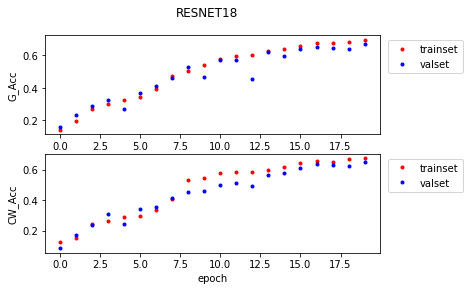

In [ ]:
accuracy_calculator18 = AccuracyCalculator(is_cuda=True)

nngraph.clear()

for epoch in range(N_EPOCHS):
  
  #training
  accuracy_calculator18.clear()
  model_resnet18.train()

  for X, y in loaders['train']:
    X = X.to(device)
    y = y.to(device)
    
    optimizer18.zero_grad()

    output18 = model_resnet18(X).to(device)

    loss18 = loss_fn(output18, y)

    y18 = output18.argmax(-1).to(device)
    accuracy_calculator18.add_data(y18, y)

    loss18.backward()

    optimizer18.step()

  gacc_trainset_18 = accuracy_calculator18.global_acc()
  cwacc_trainset_18 = accuracy_calculator18.class_wise_acc()

  print("[][]  Epoch {}/{} [][]".format(epoch+1, N_EPOCHS))
  print("Training: Sample-Wise Accuracy: {:7.2%}, Class-wise Accuracy: {:7.2%}".format(gacc_trainset_18, cwacc_trainset_18))

  #validation
  accuracy_calculator18.clear()
  model_resnet18.eval()

  with torch.no_grad():
    for X, y in loaders['val']:
      X = X.to(device)
      y = y.to(device)

      output18 = model_resnet18(X).to(device)

      y18 = output18.argmax(-1).to(device)
      accuracy_calculator18.add_data(y18, y)

  gacc_valset_18 = accuracy_calculator18.global_acc()
  cwacc_valset_18 = accuracy_calculator18.class_wise_acc()

  nngraph.add_data(epoch, gacc_trainset_18, gacc_valset_18, cwacc_trainset_18, cwacc_valset_18)

  print("Validation: Sample-Wise Accuracy: {:7.2%}, Class-wise Accuracy: {:7.2%}".format(gacc_valset_18, cwacc_valset_18))
  scheduler18.step()

save_model(model_resnet18, optimizer18, 19, loss18, "/content/drive/My Drive/ML/Saved Models/resnet_18.pt")

nngraph.rename("RESNET18")
nngraph.display("epoch")

**RESNET50**

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


[][]  Epoch 1/20 [][]
Training: Global Accuracy:  19.82%, Class-wise Accuracy:  15.64%
Validation: Global Accuracy:  25.21%, Class-wise Accuracy:   8.15%
[][]  Epoch 2/20 [][]
Training: Global Accuracy:  25.80%, Class-wise Accuracy:  22.32%
Validation: Global Accuracy:  30.17%, Class-wise Accuracy:  16.84%
[][]  Epoch 3/20 [][]
Training: Global Accuracy:  37.51%, Class-wise Accuracy:  32.98%
Validation: Global Accuracy:  31.49%, Class-wise Accuracy:  33.39%
[][]  Epoch 4/20 [][]
Training: Global Accuracy:  45.46%, Class-wise Accuracy:  39.02%
Validation: Global Accuracy:  51.11%, Class-wise Accuracy:  49.50%
[][]  Epoch 5/20 [][]
Training: Global Accuracy:  54.83%, Class-wise Accuracy:  55.18%
Validation: Global Accuracy:  42.33%, Class-wise Accuracy:  39.95%
[][]  Epoch 6/20 [][]
Training: Global Accuracy:  58.14%, Class-wise Accuracy:  54.91%
Validation: Global Accuracy:  40.31%, Class-wise Accuracy:  42.48%
[][]  Epoch 7/20 [][]
Training: Global Accuracy:  62.47%, Class-wise Accurac

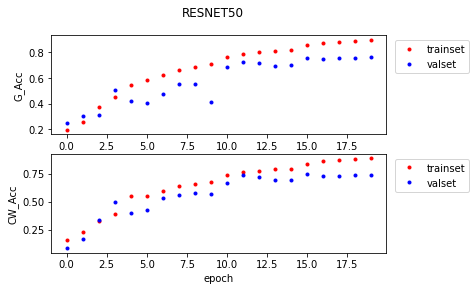

In [ ]:
accuracy_calculator50 = AccuracyCalculator(is_cuda=True)

nngraph.clear()

for epoch in range(N_EPOCHS):
  
  #training
  accuracy_calculator50.clear()
  model_resnet50.train()

  for X, y in loaders['train']:
    X = X.to(device)
    y = y.to(device)

    optimizer50.zero_grad()

    output50 = model_resnet50(X).to(device)

    loss50 = loss_fn(output50, y)

    y50 = output50.argmax(-1).to(device)
    accuracy_calculator50.add_data(y50, y)

    loss50.backward()

    optimizer50.step()

  gacc_trainset_50 = accuracy_calculator50.global_acc()
  cwacc_trainset_50 = accuracy_calculator50.class_wise_acc()

  print("[][]  Epoch {}/{} [][]".format(epoch+1, N_EPOCHS))
  print("Training: Sample-Wise Accuracy: {:7.2%}, Class-wise Accuracy: {:7.2%}".format(gacc_trainset_50, cwacc_trainset_50))

  #validation
  accuracy_calculator50.clear()
  model_resnet50.eval()

  with torch.no_grad():
    for X, y in loaders['val']:
      X = X.to(device)
      y = y.to(device)

      output50 = model_resnet50(X).to(device)

      y50 = output50.argmax(-1).to(device)
      accuracy_calculator50.add_data(y50, y)

  gacc_valset_50 = accuracy_calculator50.global_acc()
  cwacc_valset_50 = accuracy_calculator50.class_wise_acc()

  nngraph.add_data(epoch, gacc_trainset_50, gacc_valset_50, cwacc_trainset_50, cwacc_valset_50)

  print("Validation: Sample-Wise Accuracy: {:7.2%}, Class-wise Accuracy: {:7.2%}".format(gacc_valset_50, cwacc_valset_50))

  scheduler50.step()

save_model(model_resnet50, optimizer50, 19, loss50, "/content/drive/My Drive/ML/Saved Models/resnet_50.pt")

nngraph.rename("RESNET50")
nngraph.display("epoch")

**MLP - Multi Layer Perceptron** 

In [ ]:
class MultiLayerPerceptron(nn.Module):
  def __init__(self, input_dim, hidden_dim_1, hidden_dim_2, output_dim):
    super(MultiLayerPerceptron, self).__init__()

    self.output_dim = output_dim

    self.flatten = nn.Flatten()
    self.hidden1 = nn.Linear(input_dim, hidden_dim_1)
    self.hidden2 = nn.Linear(hidden_dim_1, hidden_dim_2)
    self.output = nn.Linear(hidden_dim_2, output_dim)

    self.activation = nn.Sigmoid()

  def forward(self, x):
    x = self.flatten(x)
    x = self.hidden1(x)
    x = self.activation(x) 
    x = self.hidden2(x)
    x = self.activation(x)
    return self.output(x)

In [ ]:
model_mlp1 = MultiLayerPerceptron(INPUT_DIM, 1024, 128, N_CLASSES).to(device)
model_mlp2 = MultiLayerPerceptron(INPUT_DIM, 1024, 256, N_CLASSES).to(device)
model_mlp3 = MultiLayerPerceptron(INPUT_DIM, 2048, 128, N_CLASSES).to(device)
model_mlp4 = MultiLayerPerceptron(INPUT_DIM, 2048, 256, N_CLASSES).to(device)

optimizer_mlp1 = optim.SGD(model_mlp1.parameters(), lr=0.1, momentum=0.9)
scheduler_mlp1 = optim.lr_scheduler.MultiStepLR(optimizer_mlp1, [10,15], gamma=0.5)

optimizer_mlp2 = optim.SGD(model_mlp2.parameters(), lr=0.1, momentum=0.9)
scheduler_mlp2 = optim.lr_scheduler.MultiStepLR(optimizer_mlp2, [10,15], gamma=0.5)

optimizer_mlp3 = optim.SGD(model_mlp3.parameters(), lr=0.1, momentum=0.9)
scheduler_mlp3 = optim.lr_scheduler.MultiStepLR(optimizer_mlp3, [10,15], gamma=0.5)

optimizer_mlp4 = optim.SGD(model_mlp4.parameters(), lr=0.1, momentum=0.9)
scheduler_mlp4 = optim.lr_scheduler.MultiStepLR(optimizer_mlp4, [10,15], gamma=0.5)

accuracy_calculator_mlp = AccuracyCalculator(is_cuda=True)

**Loader without normalization for MLP**

In [ ]:
def load_and_split_mlp():

  #transformation tools
  tr_composition = transforms.Compose([
                  transforms.Resize(256),
                  transforms.CenterCrop(224),
                  transforms.ToTensor()           
                ])

  #data folders
  folders = { x : datasets.ImageFolder(TRAIN_DATASET_DIR, transform = tr_composition) for x in ['train', 'val']}

  #split training and validation datasets
  train_set_size = len(folders['train'])
  indexes = list(range(train_set_size))
  split = int(np.floor(DATA_FOR_VALIDATION * train_set_size))
  np.random.shuffle(indexes)

  index = {'train': indexes[split:], 'val': indexes[:split]}

  sampler = {'train': SubsetRandomSampler(index['train']), 'val': SubsetRandomSampler(index['val'])}

  #define data loaders
  loaders = {x : torch.utils.data.DataLoader(folders[x], sampler=sampler[x], batch_size=BATCH_SIZE) for x in ['train', 'val']}
  
  test_folder = datasets.ImageFolder(TEST_DATASET_DIR, transform = tr_composition)

  test_loader = torch.utils.data.DataLoader(test_folder, batch_size=BATCH_SIZE)

  return loaders, test_loader

loaders_mlp, test_loader_mlp = load_and_split_mlp()

**MLP-1**

[][]  Epoch 1/20 [][]
Training: Global Accuracy:  73.65%, Class-wise Accuracy:  74.02%
Validation: Global Accuracy:  55.13%, Class-wise Accuracy:  53.06%
[][]  Epoch 2/20 [][]
Training: Global Accuracy:  77.84%, Class-wise Accuracy:  78.10%
Validation: Global Accuracy:  54.89%, Class-wise Accuracy:  52.68%
[][]  Epoch 3/20 [][]
Training: Global Accuracy:  78.32%, Class-wise Accuracy:  78.63%
Validation: Global Accuracy:  56.67%, Class-wise Accuracy:  54.33%
[][]  Epoch 4/20 [][]
Training: Global Accuracy:  79.32%, Class-wise Accuracy:  79.62%
Validation: Global Accuracy:  54.61%, Class-wise Accuracy:  52.32%
[][]  Epoch 5/20 [][]
Training: Global Accuracy:  82.06%, Class-wise Accuracy:  82.54%
Validation: Global Accuracy:  53.85%, Class-wise Accuracy:  54.71%
[][]  Epoch 6/20 [][]
Training: Global Accuracy:  81.98%, Class-wise Accuracy:  82.04%
Validation: Global Accuracy:  57.31%, Class-wise Accuracy:  53.12%
[][]  Epoch 7/20 [][]
Training: Global Accuracy:  78.82%, Class-wise Accurac

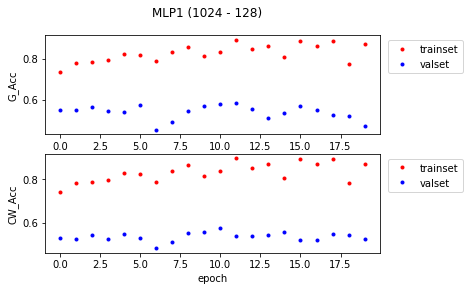

In [ ]:
nngraph.clear()

for epoch in range(N_EPOCHS):
  
  #training
  accuracy_calculator_mlp.clear()
  model_mlp1.train()

  for X, y in loaders_mlp['train']:
    X = X.to(device)
    y = y.to(device)

    optimizer_mlp1.zero_grad()

    output_mlp1 = model_mlp1(X).to(device)

    loss_mlp1 = loss_fn(output_mlp1, y)

    y_mlp1 = output_mlp1.argmax(-1).to(device)
    accuracy_calculator_mlp.add_data(y_mlp1, y)

    loss_mlp1.backward()

    optimizer_mlp1.step()

  gacc_trainset_mlp = accuracy_calculator_mlp.global_acc()
  cwacc_trainset_mlp = accuracy_calculator_mlp.class_wise_acc()

  print("[][]  Epoch {}/{} [][]".format(epoch+1, N_EPOCHS))
  print("Training: Sample-Wise Accuracy: {:7.2%}, Class-wise Accuracy: {:7.2%}".format(gacc_trainset_mlp, cwacc_trainset_mlp))

  #validation
  accuracy_calculator_mlp.clear()
  model_mlp1.eval()

  with torch.no_grad():
    for X, y in loaders_mlp['val']:
      X = X.to(device)
      y = y.to(device)

      output_mlp1 = model_mlp1(X).to(device)

      y_mlp1 = output_mlp1.argmax(-1).to(device)
      accuracy_calculator_mlp.add_data(y_mlp1, y)

  gacc_valset_mlp = accuracy_calculator_mlp.global_acc()
  cwacc_valset_mlp = accuracy_calculator_mlp.class_wise_acc()

  nngraph.add_data(epoch, gacc_trainset_mlp, gacc_valset_mlp, cwacc_trainset_mlp, cwacc_valset_mlp)

  print("Validation: Sample-Wise Accuracy: {:7.2%}, Class-wise Accuracy: {:7.2%}".format(gacc_valset_mlp, cwacc_valset_mlp))

  scheduler_mlp1.step()

save_model(model_mlp1, optimizer_mlp1, 19, loss_mlp1, "/content/drive/My Drive/ML/Saved Models/mlp1.pt")

nngraph.rename("MLP1 (1024 - 128)")
nngraph.display("epoch")

**MLP-2**

[][]  Epoch 1/20 [][]
Training: Global Accuracy:  16.65%, Class-wise Accuracy:   9.20%
Validation: Global Accuracy:  23.20%, Class-wise Accuracy:   7.52%
[][]  Epoch 2/20 [][]
Training: Global Accuracy:  22.47%, Class-wise Accuracy:  15.99%
Validation: Global Accuracy:  24.16%, Class-wise Accuracy:   9.11%
[][]  Epoch 3/20 [][]
Training: Global Accuracy:  25.17%, Class-wise Accuracy:  19.97%
Validation: Global Accuracy:  29.36%, Class-wise Accuracy:  20.00%
[][]  Epoch 4/20 [][]
Training: Global Accuracy:  31.09%, Class-wise Accuracy:  25.12%
Validation: Global Accuracy:  32.82%, Class-wise Accuracy:  28.30%
[][]  Epoch 5/20 [][]
Training: Global Accuracy:  35.13%, Class-wise Accuracy:  30.49%
Validation: Global Accuracy:  29.72%, Class-wise Accuracy:  27.13%
[][]  Epoch 6/20 [][]
Training: Global Accuracy:  36.38%, Class-wise Accuracy:  30.55%
Validation: Global Accuracy:  42.13%, Class-wise Accuracy:  36.08%
[][]  Epoch 7/20 [][]
Training: Global Accuracy:  40.83%, Class-wise Accurac

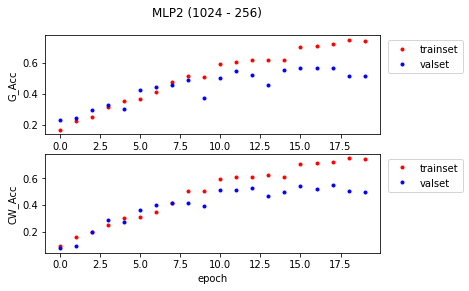

In [ ]:
nngraph.clear()

for epoch in range(N_EPOCHS):
  
  #training
  accuracy_calculator_mlp.clear()
  model_mlp2.train()

  for X, y in loaders_mlp['train']:
    X = X.to(device)
    y = y.to(device)

    optimizer_mlp2.zero_grad()

    output_mlp2 = model_mlp2(X).to(device)

    loss_mlp2 = loss_fn(output_mlp2, y)

    y_mlp2 = output_mlp2.argmax(-1).to(device)
    accuracy_calculator_mlp.add_data(y_mlp2, y)

    loss_mlp2.backward()

    optimizer_mlp2.step()

  gacc_trainset_mlp = accuracy_calculator_mlp.global_acc()
  cwacc_trainset_mlp = accuracy_calculator_mlp.class_wise_acc()

  print("[][]  Epoch {}/{} [][]".format(epoch+1, N_EPOCHS))
  print("Training: Sample-Wise Accuracy: {:7.2%}, Class-wise Accuracy: {:7.2%}".format(gacc_trainset_mlp, cwacc_trainset_mlp))

  #validation
  accuracy_calculator_mlp.clear()
  model_mlp2.eval()

  with torch.no_grad():
    for X, y in loaders_mlp['val']:
      X = X.to(device)
      y = y.to(device)

      output_mlp2 = model_mlp2(X).to(device)

      y_mlp2 = output_mlp2.argmax(-1).to(device)
      accuracy_calculator_mlp.add_data(y_mlp2, y)

  gacc_valset_mlp = accuracy_calculator_mlp.global_acc()
  cwacc_valset_mlp = accuracy_calculator_mlp.class_wise_acc()

  nngraph.add_data(epoch, gacc_trainset_mlp, gacc_valset_mlp, cwacc_trainset_mlp, cwacc_valset_mlp)

  print("Validation: Sample-Wise Accuracy: {:7.2%}, Class-wise Accuracy: {:7.2%}".format(gacc_valset_mlp, cwacc_valset_mlp))

  scheduler_mlp2.step()

save_model(model_mlp2, optimizer_mlp2, 19, loss_mlp2, "/content/drive/My Drive/ML/Saved Models/mlp2.pt")

nngraph.rename("MLP2 (1024 - 256)")
nngraph.display("epoch")

**MLP-3**

[][]  Epoch 1/20 [][]
Training: Global Accuracy:  17.41%, Class-wise Accuracy:  11.45%
Validation: Global Accuracy:  23.00%, Class-wise Accuracy:  11.34%
[][]  Epoch 2/20 [][]
Training: Global Accuracy:  24.99%, Class-wise Accuracy:  19.64%
Validation: Global Accuracy:  27.87%, Class-wise Accuracy:  20.10%
[][]  Epoch 3/20 [][]
Training: Global Accuracy:  29.54%, Class-wise Accuracy:  23.74%
Validation: Global Accuracy:  31.21%, Class-wise Accuracy:  28.10%
[][]  Epoch 4/20 [][]
Training: Global Accuracy:  32.35%, Class-wise Accuracy:  25.78%
Validation: Global Accuracy:  31.21%, Class-wise Accuracy:  26.84%
[][]  Epoch 5/20 [][]
Training: Global Accuracy:  35.24%, Class-wise Accuracy:  28.31%
Validation: Global Accuracy:  34.64%, Class-wise Accuracy:  28.69%
[][]  Epoch 6/20 [][]
Training: Global Accuracy:  39.22%, Class-wise Accuracy:  35.00%
Validation: Global Accuracy:  37.49%, Class-wise Accuracy:  33.69%
[][]  Epoch 7/20 [][]
Training: Global Accuracy:  44.59%, Class-wise Accurac

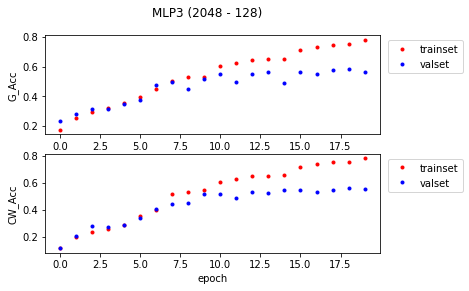

In [ ]:
nngraph.clear()

for epoch in range(N_EPOCHS):
  
  #training
  accuracy_calculator_mlp.clear()
  model_mlp3.train()

  for X, y in loaders_mlp['train']:
    X = X.to(device)
    y = y.to(device)

    optimizer_mlp3.zero_grad()

    output_mlp3 = model_mlp3(X).to(device)

    loss_mlp3 = loss_fn(output_mlp3, y)

    y_mlp3 = output_mlp3.argmax(-1).to(device)
    accuracy_calculator_mlp.add_data(y_mlp3, y)

    loss_mlp3.backward()

    optimizer_mlp3.step()

  gacc_trainset_mlp = accuracy_calculator_mlp.global_acc()
  cwacc_trainset_mlp = accuracy_calculator_mlp.class_wise_acc()

  print("[][]  Epoch {}/{} [][]".format(epoch+1, N_EPOCHS))
  print("Training: Sample-Wise Accuracy: {:7.2%}, Class-wise Accuracy: {:7.2%}".format(gacc_trainset_mlp, cwacc_trainset_mlp))

  #validation
  accuracy_calculator_mlp.clear()
  model_mlp3.eval()

  with torch.no_grad():
    for X, y in loaders_mlp['val']:
      X = X.to(device)
      y = y.to(device)

      output_mlp3 = model_mlp3(X).to(device)

      y_mlp3 = output_mlp3.argmax(-1).to(device)
      accuracy_calculator_mlp.add_data(y_mlp3, y)

  gacc_valset_mlp = accuracy_calculator_mlp.global_acc()
  cwacc_valset_mlp = accuracy_calculator_mlp.class_wise_acc()

  nngraph.add_data(epoch, gacc_trainset_mlp, gacc_valset_mlp, cwacc_trainset_mlp, cwacc_valset_mlp)

  print("Validation: Sample-Wise Accuracy: {:7.2%}, Class-wise Accuracy: {:7.2%}".format(gacc_valset_mlp, cwacc_valset_mlp))

  scheduler_mlp3.step()

save_model(model_mlp3, optimizer_mlp3, 19, loss_mlp3, "/content/drive/My Drive/ML/Saved Models/mlp3.pt")

nngraph.rename("MLP3 (2048 - 128)")
nngraph.display("epoch")

**MLP-4**

[][]  Epoch 1/20 [][]
Training: Global Accuracy:  18.41%, Class-wise Accuracy:  11.69%
Validation: Global Accuracy:  20.30%, Class-wise Accuracy:  10.43%
[][]  Epoch 2/20 [][]
Training: Global Accuracy:  23.54%, Class-wise Accuracy:  19.11%
Validation: Global Accuracy:  24.00%, Class-wise Accuracy:   9.06%
[][]  Epoch 3/20 [][]
Training: Global Accuracy:  28.10%, Class-wise Accuracy:  22.38%
Validation: Global Accuracy:  27.43%, Class-wise Accuracy:  25.44%
[][]  Epoch 4/20 [][]
Training: Global Accuracy:  32.51%, Class-wise Accuracy:  28.13%
Validation: Global Accuracy:  31.49%, Class-wise Accuracy:  26.40%
[][]  Epoch 5/20 [][]
Training: Global Accuracy:  32.91%, Class-wise Accuracy:  28.06%
Validation: Global Accuracy:  35.64%, Class-wise Accuracy:  27.59%
[][]  Epoch 6/20 [][]
Training: Global Accuracy:  35.59%, Class-wise Accuracy:  29.58%
Validation: Global Accuracy:  35.68%, Class-wise Accuracy:  31.56%
[][]  Epoch 7/20 [][]
Training: Global Accuracy:  39.51%, Class-wise Accurac

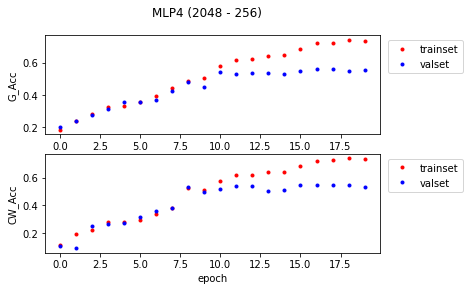

In [ ]:
nngraph.clear()

for epoch in range(N_EPOCHS):
  
  #training
  accuracy_calculator_mlp.clear()
  model_mlp4.train()

  for X, y in loaders_mlp['train']:
    X = X.to(device)
    y = y.to(device)

    optimizer_mlp4.zero_grad()

    output_mlp4 = model_mlp4(X).to(device)

    loss_mlp4 = loss_fn(output_mlp4, y)

    y_mlp4 = output_mlp4.argmax(-1).to(device)
    accuracy_calculator_mlp.add_data(y_mlp4, y)

    loss_mlp4.backward()

    optimizer_mlp4.step()

  gacc_trainset_mlp = accuracy_calculator_mlp.global_acc()
  cwacc_trainset_mlp = accuracy_calculator_mlp.class_wise_acc()

  print("[][]  Epoch {}/{} [][]".format(epoch+1, N_EPOCHS))
  print("Training: Sample-Wise Accuracy: {:7.2%}, Class-wise Accuracy: {:7.2%}".format(gacc_trainset_mlp, cwacc_trainset_mlp))

  #validation
  accuracy_calculator_mlp.clear()
  model_mlp4.eval()

  with torch.no_grad():
    for X, y in loaders_mlp['val']:
      X = X.to(device)
      y = y.to(device)

      output_mlp4 = model_mlp4(X).to(device)

      y_mlp4 = output_mlp4.argmax(-1).to(device)
      accuracy_calculator_mlp.add_data(y_mlp4, y)

  gacc_valset_mlp = accuracy_calculator_mlp.global_acc()
  cwacc_valset_mlp = accuracy_calculator_mlp.class_wise_acc()

  nngraph.add_data(epoch, gacc_trainset_mlp, gacc_valset_mlp, cwacc_trainset_mlp, cwacc_valset_mlp)

  print("Validation: Sample-Wise Accuracy: {:7.2%}, Class-wise Accuracy: {:7.2%}".format(gacc_valset_mlp, cwacc_valset_mlp))

  scheduler_mlp4.step()

save_model(model_mlp4, optimizer_mlp4, 19, loss_mlp4, "/content/drive/My Drive/ML/Saved Models/mlp4.pt")

nngraph.rename("MLP4 (2048 - 256)")
nngraph.display("epoch")

# Test

**Il test è stato fatto con ResNet50 + SVM Lineare con C=1**

In [ ]:
class ImageFolderWithPath(datasets.ImageFolder):
    def __getitem__(self, index):
        return super().__getitem__(index), self.imgs[index][0]

In [ ]:
paths = ImageFolderWithPath(TEST_DATASET_DIR)
class_names = ["Barred Spiral", "Cigar Shaped Smooth", "Disturbed", "Edge-on with Bulge" ,"Edge-on without Bulge", "In-between Round Smooth", "Merging", "Round Smooth", "Unbarred Loose Spiral", "Unbarred Tight Spiral"]

In [ ]:
def write_output():
  paths = ImageFolderWithPath(TEST_DATASET_DIR)

  with open("/content/drive/My Drive/ML/output.csv", "w", newline="") as csv_file:
    csv_writer = csv.writer(csv_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL)

    lines = {}

    for img_index, img_class in enumerate(predicted_labels_testset):
      path = paths.__getitem__(img_index)[1]
      path = path.replace(TEST_DATASET_DIR+"/test/",'')
      path = path.replace('.png', '')
      lines[path] = class_names[img_class]
      
    for image_id in range(5321):
      class_name = lines[str(image_id)]
      csv_writer.writerow([image_id, class_name])

write_output()